# Classical Bayesian optimisation

In [1]:
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from functools import partial

In [2]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

In [3]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [4]:
sns.set_palette("colorblind")
plt.rcParams["figure.figsize"] = (7.2, 4.2)

In [5]:
jnp.set_printoptions(suppress=False, precision=8, linewidth=200)

In [6]:
%config InlineBackend.figure_format = "retina"

In [7]:
def plot_hist(ax, runs, **kwargs):
    steps = np.arange(len(runs[0]))
    med_run = np.quantile(runs, 0.5, axis=0)
    # med_run = np.mean(runs, axis=0)
    lbound = np.quantile(runs, 0.25, axis=0)
    ubound = np.quantile(runs, 0.75, axis=0)

    
    ax.plot(med_run, **kwargs)
    ax.fill_between(steps, lbound, ubound, alpha=0.4)

## Eval experiments

In [ ]:
from bayesopt import test_functions, eval_fn, agents

In [14]:
key = jax.random.PRNGKey(314)
key_init_params, key_run = jax.random.split(key)

In [17]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ nndraw50

*** Running nndraw50 ***
GP agent not available for grad query method
Eval laplace
Eval VBLL-greedy
Eval VBLL
Eval FLoRES
Eval LRKF
Eval LOFI
CPU times: user 2min 20s, sys: 4.01 s, total: 2min 24s
Wall time: 1min 57s


In [18]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ nndraw200

*** Running nndraw200 ***
GP agent not available for grad query method
Eval laplace
Eval VBLL-greedy
Eval VBLL
Eval FLoRES
Eval LRKF
Eval LOFI
CPU times: user 2min 33s, sys: 5.07 s, total: 2min 38s
Wall time: 5min 3s


In [19]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ branin

*** Running branin ***
Eval GP
Eval laplace
Eval VBLL-greedy
Eval VBLL
Eval FLoRES
Eval LRKF
Eval LOFI
CPU times: user 14min 37s, sys: 1min, total: 15min 38s
Wall time: 2min 17s


In [20]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ hartmann

*** Running hartmann ***
Eval GP
Eval laplace
Eval VBLL-greedy
Eval VBLL
Eval FLoRES
Eval LRKF
Eval LOFI
CPU times: user 14min 50s, sys: 1min 2s, total: 15min 52s
Wall time: 2min 15s


In [21]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ ackley2

*** Running ackley2 ***
Eval GP
Eval laplace
Eval VBLL-greedy
Eval VBLL
Eval FLoRES
Eval LRKF
Eval LOFI
CPU times: user 15min, sys: 1min 2s, total: 16min 3s
Wall time: 2min 12s


In [22]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ ackley5

*** Running ackley5 ***
Eval GP
Eval laplace
Eval VBLL-greedy
Eval VBLL
Eval FLoRES
Eval LRKF
Eval LOFI
CPU times: user 15min 5s, sys: 56.2 s, total: 16min 1s
Wall time: 3min 15s


In [26]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ ackley10

*** Running ackley10 ***
Eval GP
Eval laplace
Eval VBLL-greedy
Eval VBLL
Eval FLoRES
Eval LRKF
Eval LOFI
CPU times: user 15min 12s, sys: 50.5 s, total: 16min 2s
Wall time: 3min 9s


In [27]:
%%time
%run ./bayesopt/eval_bayesopt.py ./bayesopt/ ackley50

*** Running ackley50 ***
Eval GP
Eval laplace
Eval VBLL-greedy
Eval VBLL
Eval FLoRES
Eval LRKF
Eval LOFI
CPU times: user 15min 24s, sys: 47.9 s, total: 16min 12s
Wall time: 3min 12s


## Plot results

In [28]:
res_files = !ls *pkl
res_files = res_files

In [29]:
res = {}
method_explore = "thompson_sampling.pkl"
for file in res_files:
    if not file.endswith(method_explore):
        continue
    res_experiment = pd.read_pickle(file)
    res[file.split(f"_{method_explore}")[0]] = res_experiment

In [30]:
res.keys()

dict_keys(['ackley10', 'ackley2', 'ackley50', 'ackley5', 'branin', 'hartmann', 'nndraw200', 'nndraw50'])

In [31]:
def format_ticks(ax):
    ax.xaxis.set_major_locator(ticker.MaxNLocator(5))  # 5 major ticks on X-axis
    ax.yaxis.set_major_locator(ticker.MaxNLocator(5))  # 4 major ticks on Y-axis
    ax.minorticks_on()
    
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-2, 2))  # Show scale factor when outside this range
    ax.yaxis.set_major_formatter(formatter)
    
    # Make sure the offset text is at the top left
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-1, 1))
    ax.yaxis.offsetText.set_x(-0.1)  # Move offset text (e.g., ×1e3) to the left
    # ax.yaxis.set_major_formatter()

In [32]:
experiments_names = [
    "ackley2", "ackley5", "ackley10", "ackley50", "branin", "hartmann", "nndraw50", "nndraw200"
]

In [34]:
map_method = {
    "FLoRES": "HiLoFi",
    "LOFI": "LoFi",
    "LRKF": "LRKF",
    "VBLL": "VBLL",
    "VBLL-greedy": "OnVBLL",
    "laplace": "LLL",
    "GP": "GP"
}

In [35]:
colors = {method: color for method, color in zip(map_method.keys(), sns.color_palette())}

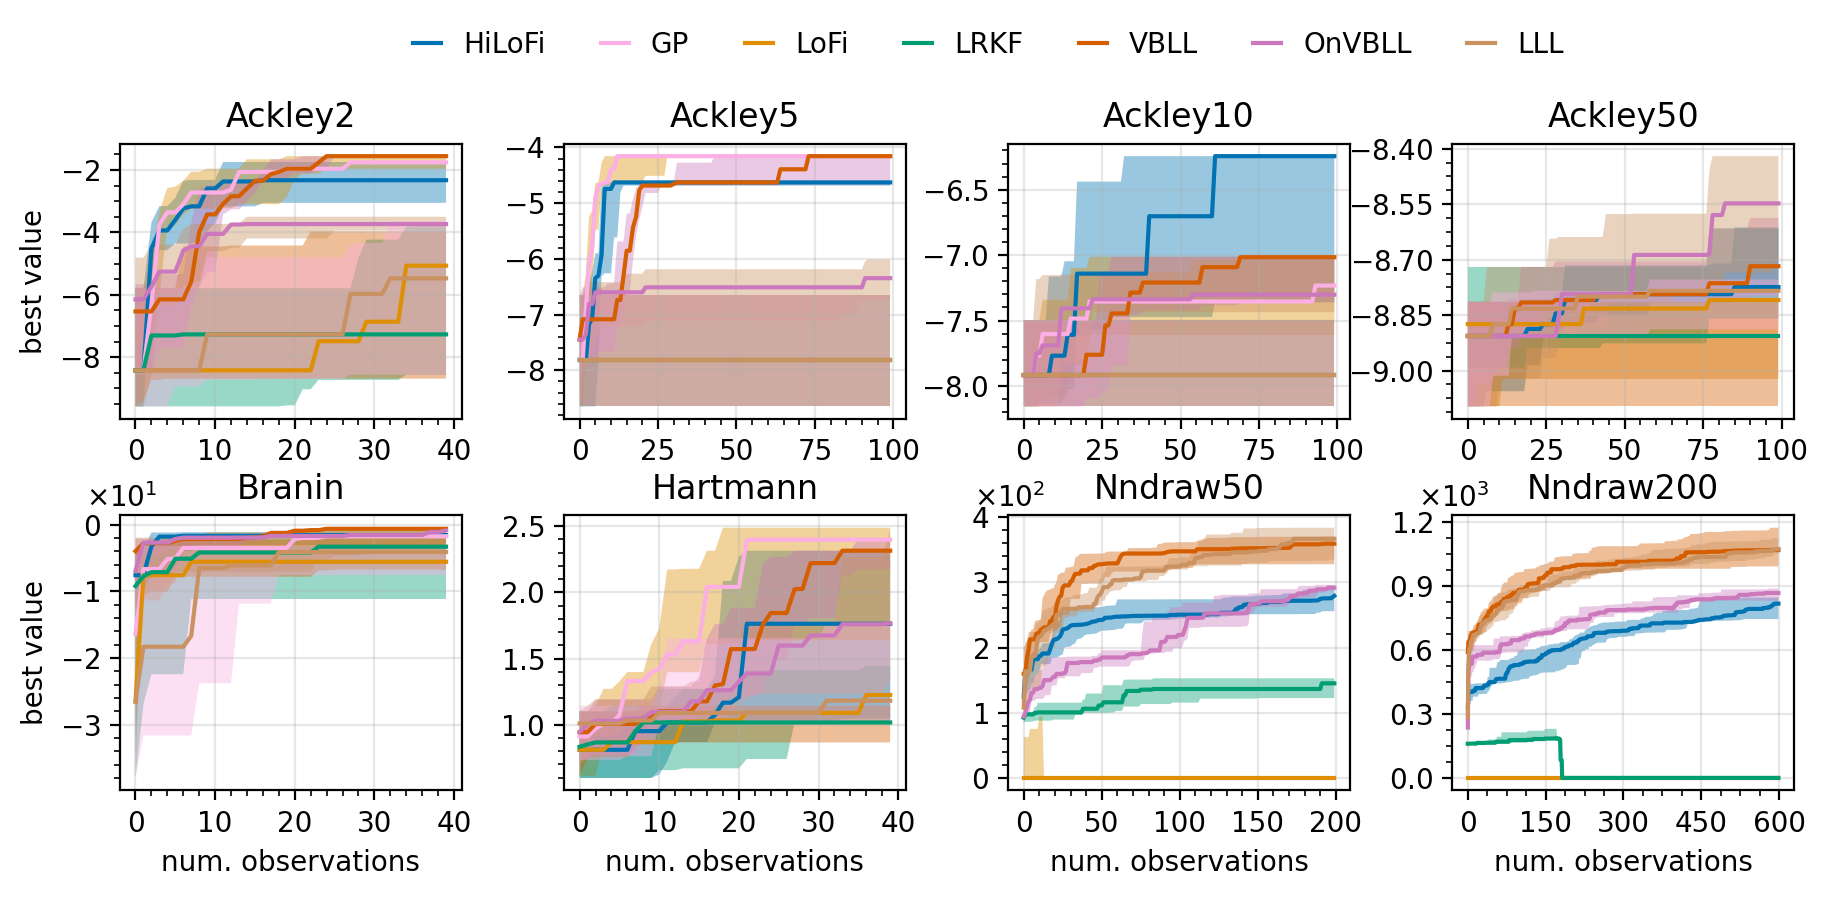

In [36]:
fig, axs = plt.subplots(2, 4, figsize=(7.2 * 1.5, 4.2))
methods = sorted(list(res["ackley2"]))

for ax, name in zip(axs.ravel(), experiments_names):
    res_experiment = res[name]
    for nmethod in sorted(res_experiment):
        name_method = map_method[nmethod]
        runs = res_experiment[nmethod]
        plot_hist(ax, runs["y_best"], label=name_method, color=colors[nmethod])
    format_ticks(ax)
    ax.set_title(name.capitalize())
    ax.grid(alpha=0.3)

axs[0,0].legend(ncol=7, bbox_to_anchor=(4.3, 1.5), frameon=False, handlelength=1)
# axs[0,0].legend(ncol=7)
# axs[-1,-1].legend()

axs[1,0].set_xlabel("num. observations")
axs[1,1].set_xlabel("num. observations")
axs[1,2].set_xlabel("num. observations")
axs[1,3].set_xlabel("num. observations")
axs[0,0].set_ylabel("best value")
axs[1,0].set_ylabel("best value")
plt.subplots_adjust(hspace=0.35, wspace=0.3)
plt.savefig(f"../figures/bayesopt-iterations-{method_explore.replace("_", "-")}.png", dpi=300, bbox_inches="tight")

In [37]:
summary = []
for ax, name in zip(axs.ravel(), experiments_names):
    res_experiment = res[name]
    for name_method in sorted(res_experiment):
        runs = res_experiment[name_method]

        summary.append({
            "y_best": runs["y_best"][:, -1].mean(),
            "y_best_std": runs["y_best"][:, -1].std(),
            "time": runs["time"],
            "method": name_method,
            "experiment": name
        })
summary =pd.DataFrame(summary)

summary["time"] = summary["time"].astype(float)

In [38]:
colors_new = {
    map_method[name]: color
    for name, color in colors.items()
}

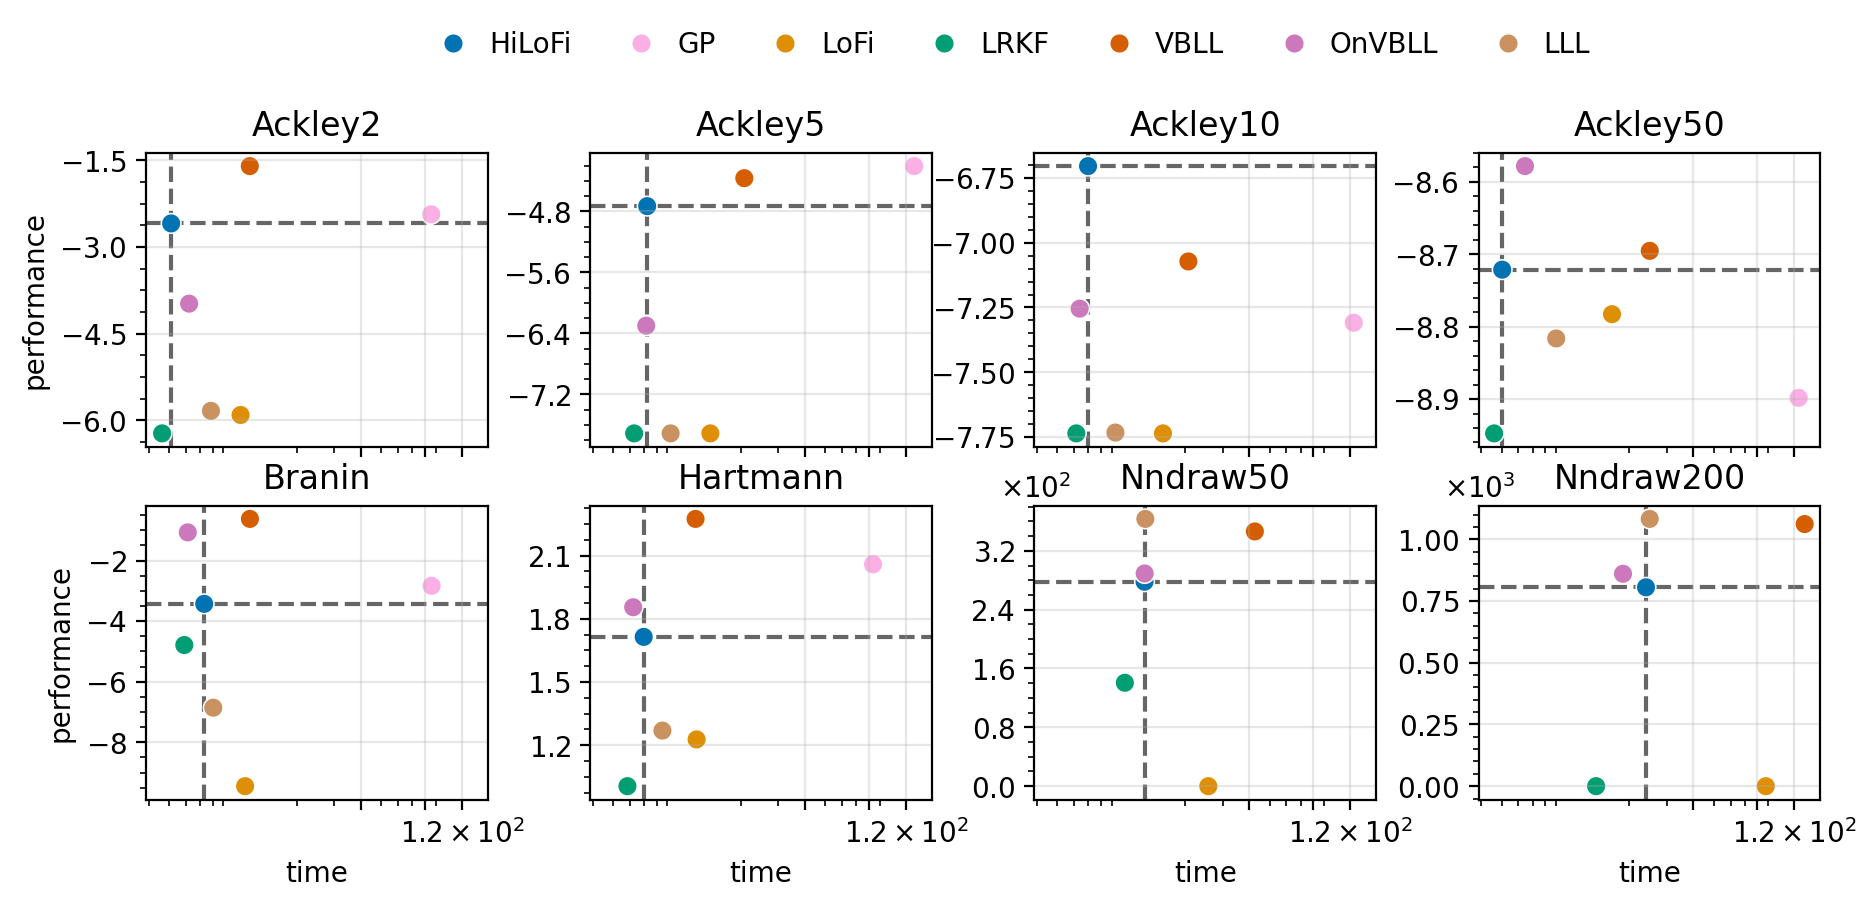

In [39]:
fig, axs = plt.subplots(2, 4, sharex=True, figsize=(7.2 * 1.5, 4.2))

experiments = summary["experiment"].unique()
for ax, experiment in zip(axs.ravel(), experiments_names):
    sns.scatterplot(
        x="time",
        y="y_best",
        hue="method",
        data=(
            summary
            .assign(method=summary["method"].apply(lambda x: map_method[x]))
            .query("experiment == @experiment")
        ),
        ax=ax,
        palette=colors_new,
        s=50
    )
    
    v = summary.query("experiment == @experiment").query("method == 'FLoRES'")
    y = v["y_best"].item()
    x = v["time"].item()

    ax.axhline(y=y, color="black", linestyle="--", zorder=0, alpha=0.6)
    ax.axvline(x=x, color="black", linestyle="--", zorder=0, alpha=0.6)
    ax.set_title(experiment.capitalize())
    ax.grid(alpha=0.3)
    ax.set_ylabel("")
    ax.legend([], frameon=False)
    ax.set_xscale("log")
    format_ticks(ax)
    plt.grid(alpha=0.3)
axs[0,0].set_ylabel("performance")
axs[1,0].set_ylabel("performance")

plt.subplots_adjust(wspace=0.3)
legend = axs[0,0].legend(ncol=7, bbox_to_anchor=(4.3, 1.5), frameon=False, handlelength=1)
# axs[0,0].legend(loc="upper right", bbox_to_anchor=(1.9, 1.0), frameon=False)
# plt.savefig("../figures/bayesopt-time-performance.png", dpi=300, bbox_inches="tight")

In [40]:
summary.pivot_table(index="method", columns="experiment")["y_best"]

experiment,ackley10,ackley2,ackley5,ackley50,branin,hartmann,nndraw200,nndraw50
method,,,,,,,,
FLoRES,-6.704305,-2.590982,-4.729643,-8.721206,-3.430797,1.714290,805.431274,277.969543
GP,-7.308882,-2.432426,-4.204634,-8.898325,-2.835982,2.058608,NaN,NaN
LOFI,-7.735974,-5.906063,-7.710509,-8.782741,-9.449255,1.227836,0.000000,0.000000
LRKF,-7.735974,-6.225093,-7.710509,-8.947428,-4.790467,1.005835,0.000000,140.578674
VBLL,-7.072278,-1.598789,-4.362828,-8.695254,-0.626927,2.274089,1061.518311,346.322510
VBLL-greedy,-7.254537,-3.979560,-6.297515,-8.578159,-1.071544,1.855081,860.188293,289.181213
laplace,-7.732709,-5.834692,-7.710509,-8.816259,-6.857860,1.269688,1082.358643,363.377045


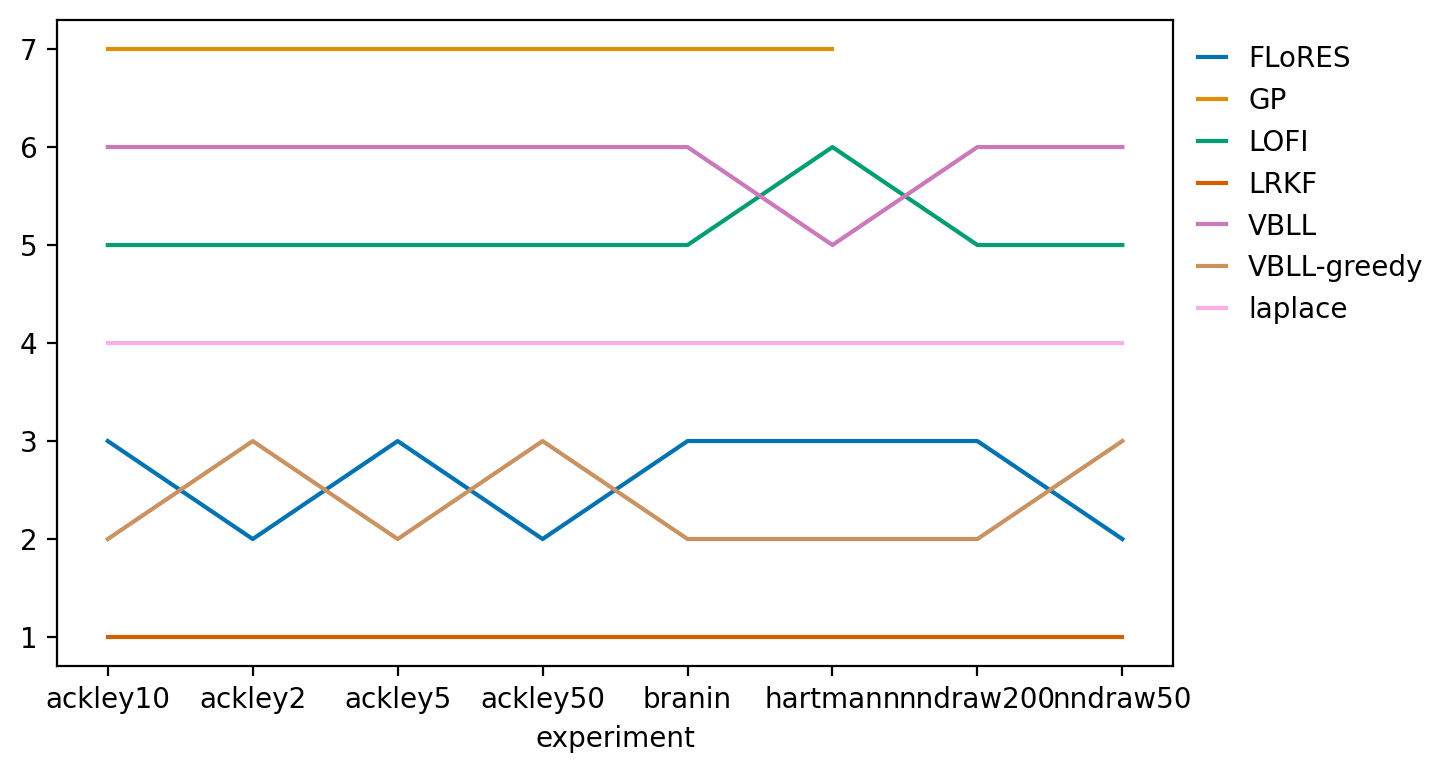

In [41]:
rank_time = summary.pivot_table(index="method", columns="experiment")["time"].rank(axis=0)
rank_time.T.plot()
plt.legend(bbox_to_anchor=(1,1), handlelength=1, frameon=False)

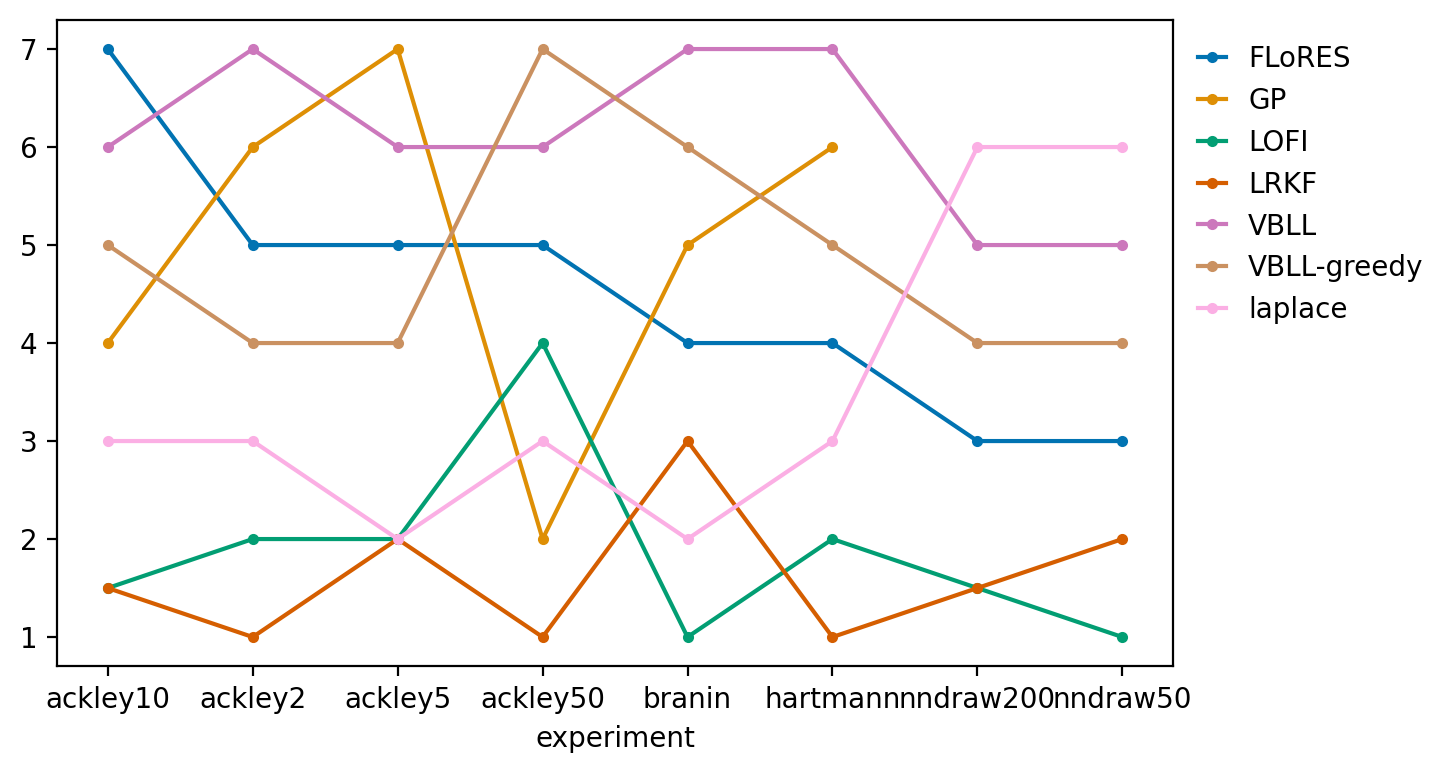

In [42]:
rank_ybest = summary.pivot_table(index="method", columns="experiment")["y_best"].rank(axis=0)
rank_ybest.T.plot(marker="o", markersize=3)
plt.legend(bbox_to_anchor=(1,1), handlelength=1, frameon=False)

In [43]:
rank_time_melt = rank_time.reset_index().melt("method").rename({"value": "time"}, axis=1)
rank_ybest_melt = rank_ybest.reset_index().melt("method").rename({"value": "ybest"}, axis=1)

In [44]:
rank_melt = pd.merge(rank_time_melt, rank_ybest_melt, on=["method", "experiment"])

In [45]:
mean_ranks = (
    rank_melt.groupby("method")[["time", "ybest"]].agg(["mean", "std"])
)

mean_ranks = mean_ranks.rename({"median": "mean"}, axis=1, level=1)

In [46]:
mean_ranks

time            ybest          
              mean       std   mean       std
method                                       
FLoRES       2.625  0.517549  4.500  1.309307
GP           7.000  0.000000  5.000  1.788854
LOFI         5.125  0.353553  1.875  0.954314
LRKF         1.000  0.000000  1.625  0.694365
VBLL         5.875  0.353553  6.125  0.834523
VBLL-greedy  2.375  0.517549  4.875  1.125992
laplace      4.000  0.000000  3.500  1.603567

In [47]:
from matplotlib.lines import Line2D

custom_legend = [
    Line2D([0], [0], color=color, lw=1, marker="o", markersize=3)
    for method, color in colors.items()
]

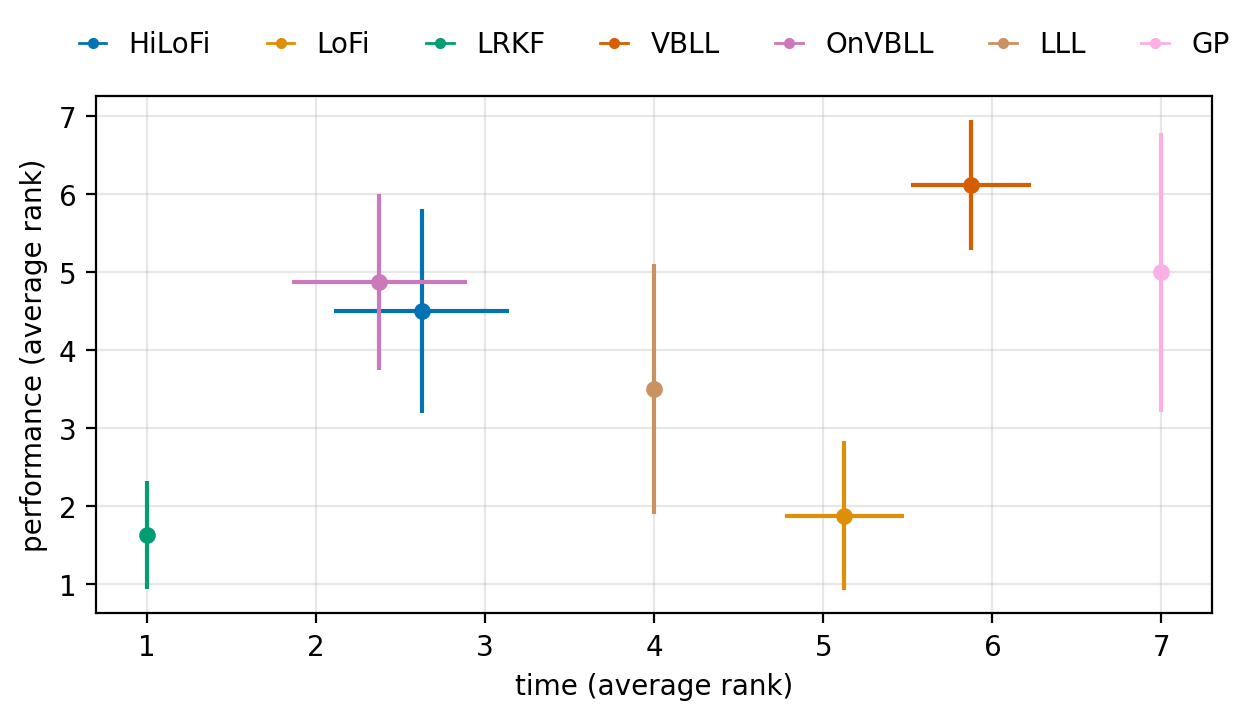

In [49]:
fig, ax = plt.subplots(figsize=(7.2, 4.2 * 0.8))

for method in methods:
    ax.errorbar(
        x=mean_ranks.xs("mean", axis=1, level=1)["time"][method],
        y=mean_ranks.xs("mean", axis=1, level=1)["ybest"][method],
        fmt="o",
        yerr=mean_ranks.xs("std", axis=1, level=1)["ybest"][method],
        xerr=mean_ranks.xs("std", axis=1, level=1)["time"][method],
        color=colors[method],
        markersize=5,
    )
# sns.scatterplot(
#     x="time",
#     y="ybest",
#     hue="method",
#     data=mean_ranks.xs("mean", axis=1, level=1).reset_index(),
# )

# plt.legend(bbox_to_anchor=(1,1))
plt.legend(
    custom_legend, [map_method[name] for name in colors],
    loc="center", ncol=7, bbox_to_anchor=(1/2, 1.1),
    handlelength=1, frameon=False
)
plt.xlabel("time (average rank)")
plt.ylabel("performance (average rank)")
plt.grid(alpha=0.3);
# plt.savefig("../figures/bayesopt-time-performance-scatter.png", dpi=300, bbox_inches="tight")

## Joint plot

In [49]:
from matplotlib.gridspec import GridSpec
from itertools import product

In [50]:
gs_indices = list(product(range(2), range(4)))

In [51]:
summary["log_time"] = np.log(summary["time"])

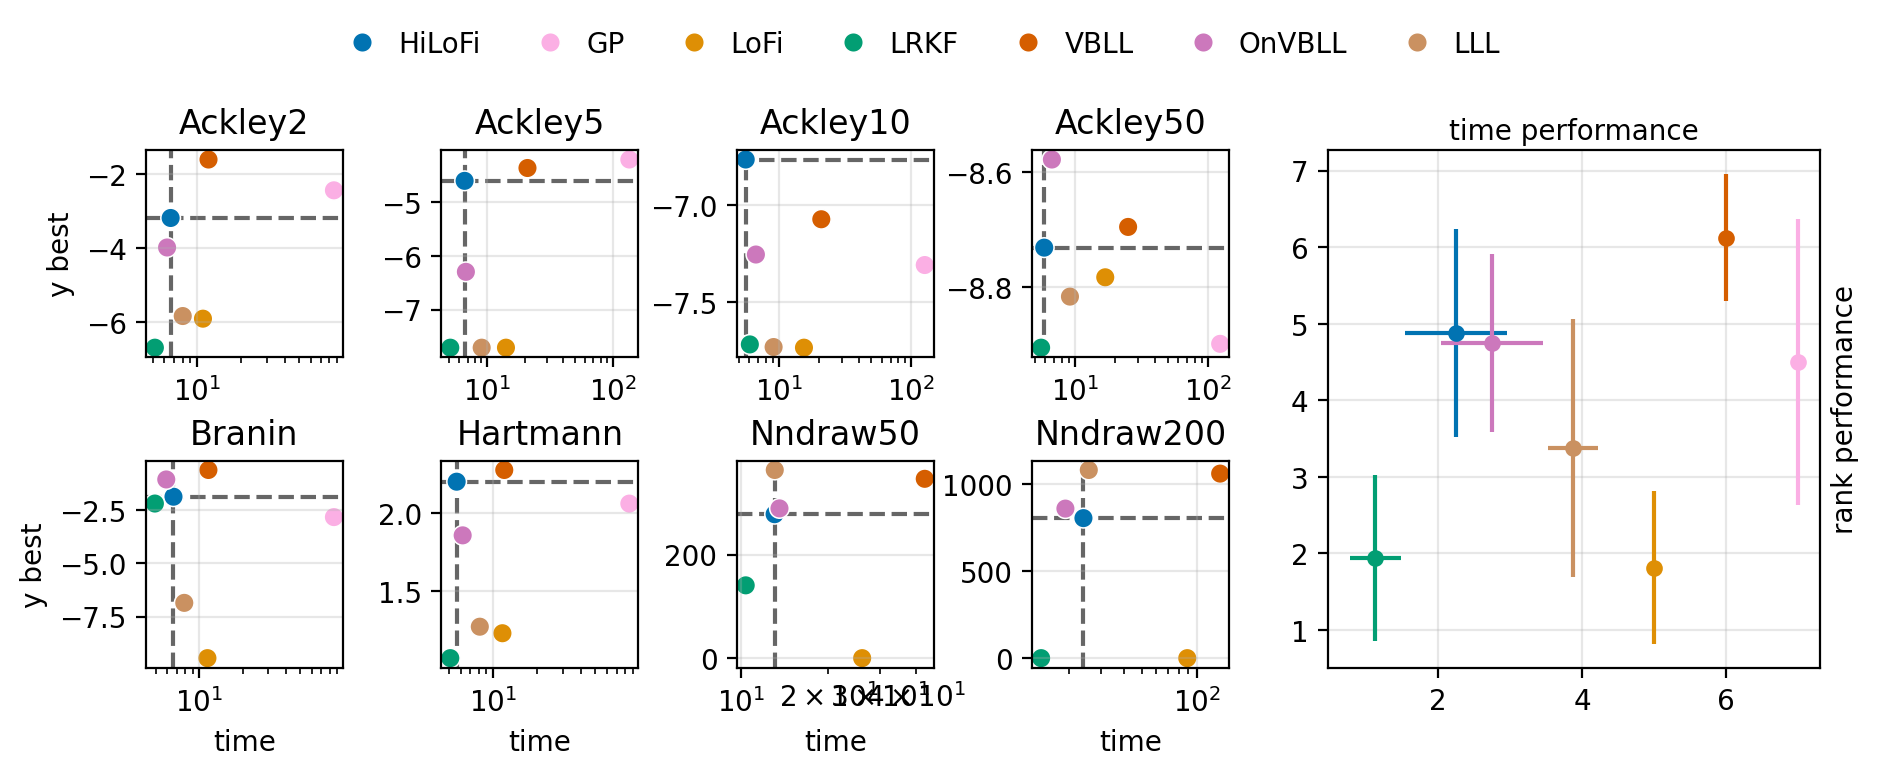

In [52]:
gs = GridSpec(2, 6)

fig = plt.figure(figsize=(7.2 * 1.5, 4.2 * 0.8))

experiments = summary["experiment"].unique()
for ix, experiment in zip(gs_indices, experiments_names):
    ax = fig.add_subplot(gs[ix])
    sns.scatterplot(
        x="time",
        y="y_best",
        hue="method",
        data=(
            summary
            .assign(method=summary["method"].apply(lambda x: map_method[x]))
            .query("experiment == @experiment")
        ),
        ax=ax,
        palette=colors_new,
        s=50
    )
    
    v = summary.query("experiment == @experiment").query("method == 'FLoRES'")
    y = v["y_best"].item()
    x = v["time"].item()

    ax.axhline(y=y, color="black", linestyle="--", zorder=0, alpha=0.6)
    ax.axvline(x=x, color="black", linestyle="--", zorder=0, alpha=0.6)
    ax.set_title(experiment.capitalize())
    ax.grid(alpha=0.3)
    ax.set_ylabel("")
    ax.legend([], frameon=False)
    ax.set_xscale("log")
    # format_ticks(ax)
    if ix[0] == 0:
        ax.set_xlabel("")
    if ix[1] == 0:
        ax.set_ylabel("y best")
    if (ix[0] == 0) and (ix[1] == 0):
        ax.legend(ncol=7, bbox_to_anchor=(7.0, 1.7), frameon=False, handlelength=1)
        
    plt.grid(alpha=0.3)

ax = fig.add_subplot(gs[:, -2:])
for method in methods:
    ax.errorbar(
        x=mean_ranks.xs("mean", axis=1, level=1)["time"][method],
        y=mean_ranks.xs("mean", axis=1, level=1)["ybest"][method],
        fmt="o",
        yerr=mean_ranks.xs("std", axis=1, level=1)["ybest"][method],
        xerr=mean_ranks.xs("std", axis=1, level=1)["time"][method],
        color=colors[method],
        markersize=5,
    )

ax.grid(alpha=0.3)
ax.set_ylabel("rank performance")
ax.yaxis.set_label_position("right")

ax.set_xlabel("time performance")
ax.xaxis.set_label_position("top")



plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig("../figures/bayesopt-time-performance-scatter.png", dpi=300, bbox_inches="tight")